In [2]:
import os
from collections import namedtuple

import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

import nengo
from nengo.utils.ensemble import tuning_curves
import nengolib
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import (meg_from_spikes, numpy_bytes_to_str,
                                         gen_added_strings, norm_spa_vecs)
from nengo_learn_assoc_mem.paths import data_path

In [3]:
nengo.rc.set("progress", "progress_bar", "nengo.utils.progress.TerminalProgressBar")

## Setup

In [4]:
with h5py.File(os.path.join(data_path, "neg_voja_enc.h5"), "r") as fi:
    print(list(fi.keys()))

    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])

    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    dimensions = fi['vocab_vectors'].attrs['dimensions']
    
    fin_enc = np.array(fi['encoders'])
    n_neurons = fin_enc.shape[0]
    intercepts = [fi['encoders'].attrs['intercept']] * n_neurons
    seed = fi['encoders'].attrs['seed']

    dt = fi['t_range'].attrs['dt']

['encoders', 'fan1', 'fan2', 'foil1', 'foil2', 't_range', 'vocab_strings', 'vocab_vectors']


In [5]:
with h5py.File(os.path.join(data_path, "bcm_rec_pos_match_weights.h5"), "r") as fi:
    
    rec_weights = np.array(fi['weights'])

In [6]:
vocab = spa.Vocabulary(dimensions)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [7]:
all_fan_vecs = fan1_pair_vecs + fan2_pair_vecs

In [8]:
t_pause = 0.2
t_present = 0.3

t_each = t_pause + t_present
td_each = int(t_each/dt)
td_pause = int(t_pause/dt)

In [9]:
fan1_slc = slice(td_pause, td_each*len(fan1_pair_vecs)+td_pause)
fan2_slc = slice(fan1_slc.stop, fan1_slc.stop+td_each*len(fan2_pair_vecs))
foil1_slc = slice(fan2_slc.stop, fan2_slc.stop+td_each*len(foil1_pair_vecs))
foil2_slc = slice(foil1_slc.stop, foil1_slc.stop+td_each*len(foil2_pair_vecs))

In [10]:
SlcStim = namedtuple("Stim", ['fan_num', 'targ', 'vecs', 'slc'])

slc_stim_vecs = {"fan1": SlcStim(1, True, np.array(fan1_pair_vecs), fan1_slc),
                 "fan2": SlcStim(2, True, np.array(fan2_pair_vecs), fan2_slc),
                 "foil1": SlcStim(1, False, np.array(foil1_pair_vecs), foil1_slc),
                 "foil2": SlcStim(2, False, np.array(foil2_pair_vecs), foil2_slc)}

## Check stable state

In [26]:
feed_vecs = fan1_pair_vecs + fan2_pair_vecs

### Analytically

In [99]:
with nengo.Network(seed=seed) as test_model:
    in_nd = nengo.Node(lambda t: feed_vecs[1])

    ens = nengo.Ensemble(n_neurons, dimensions,
                         encoders=fin_enc.copy(), intercepts=intercepts, seed=seed)

    nengo.Connection(in_nd, ens, synapse=None)
    nengo.Connection(ens.neurons, ens.neurons, transform=rec_weights, synapse=0.01)

    p_in = nengo.Probe(in_nd, synapse=None)
    p_spikes = nengo.Probe(ens.neurons, synapse=None)
    p_out = nengo.Probe(ens, synapse=0.05)

with nengo.Simulator(test_model) as test_sim:
    test_sim.run(1.5)

Build finished in 0:00:01.                                                                                   
Simulation finished in 0:00:01.                                                                              


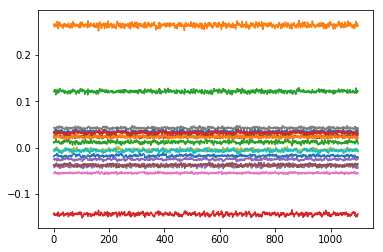

In [100]:
plt.plot(spa.similarity(test_sim.data[p_out][400:], fan1_pair_vecs));

In [101]:
lowpass = nengo.Lowpass(0.05)

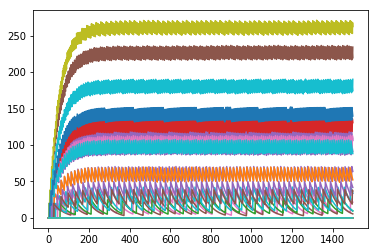

In [102]:
plt.plot(lowpass.filt(test_sim.data[p_spikes]));

In [103]:
base_est = np.sort(np.sum(test_sim.data[p_spikes][400:] > 0, axis=0)) / 1.1
base_est[base_est > 0][::-1]

array([ 260.90909091,  226.36363636,  180.90909091,  141.81818182,
        126.36363636,  112.72727273,  102.72727273,   96.36363636,
         95.45454545,   60.        ,   59.09090909,   39.09090909,
         31.81818182,   30.        ,   28.18181818,   18.18181818,
         13.63636364,   13.63636364,   10.90909091])

In [112]:
short_est = np.sort(np.sum(test_sim.data[p_spikes][400:1000] > 0, axis=0)) / 0.6
short_est[short_est > 0][::-1]

array([ 261.66666667,  225.        ,  180.        ,  141.66666667,
        126.66666667,  113.33333333,  101.66666667,   96.66666667,
         95.        ,   60.        ,   60.        ,   38.33333333,
         31.66666667,   30.        ,   28.33333333,   18.33333333,
         13.33333333,   13.33333333,   11.66666667])

In [115]:
t_diff_est = np.sort(np.abs(base_est - short_est))[::-1]
print(t_diff_est[t_diff_est > 0])
np.mean(t_diff_est[t_diff_est > 0])

[  1.36363636e+00   1.06060606e+00   9.09090909e-01   9.09090909e-01
   7.57575758e-01   7.57575758e-01   7.57575758e-01   6.06060606e-01
   4.54545455e-01   3.03030303e-01   3.03030303e-01   3.03030303e-01
   3.03030303e-01   1.51515152e-01   1.51515152e-01   1.51515152e-01
   1.51515152e-01   7.10542736e-15   3.55271368e-15]


0.49441786283891748

In [117]:
begin_est = np.sort(np.sum(test_sim.data[p_spikes][400:700] > 0, axis=0)) / 0.3
end_est = np.sort(np.sum(test_sim.data[p_spikes][700:1000] > 0, axis=0)) / 0.3
range_est = np.sort(np.abs(begin_est - end_est))[::-1]
print(range_est[range_est > 0])
np.mean(range_est[range_est > 0])

[ 3.33333333  3.33333333  3.33333333  3.33333333  3.33333333  3.33333333
  3.33333333  3.33333333  3.33333333  3.33333333]


3.3333333333333393